# 风险平价组合-择时

根据一些择时指标在风险平价组合的基础上进行择时操作以提升收益率

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [3]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [4]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [5]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI,CBA00401.CS,CBA02701.CS
2018-10-16,3246.2767,25462.26,2809.92,183.5372,274.25,81.56,1501.0483,1165.6896,180.4601,171.5733
2018-10-17,3268.2958,25462.26,2809.21,183.5771,273.74,80.36,1501.1719,1185.4492,180.4989,171.6014
2018-10-18,3179.5353,25454.55,2768.78,183.7196,273.65,78.77,1501.2935,1167.0738,180.7241,171.6561
2018-10-19,3263.7825,25561.40,2767.78,183.7705,274.20,79.54,1501.4176,1155.1030,180.7736,171.6891
2018-10-22,3412.7501,26153.15,2755.88,183.7849,274.70,79.57,1501.4176,1161.2828,180.7003,171.7606


# 标准风险平价

In [6]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [7]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return assets_risk_contribution

In [8]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

In [9]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [11]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', 'CBA00401.CS', 'CBA02701.CS']]

In [75]:
df = df.replace([0], np.NAN)

In [76]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [77]:
covariances = ret_df.iloc[-242:].cov()

In [78]:
empyrical.annual_volatility(ret_df['SPX.GI'])

0.20013630623278839

### 计算权重

In [79]:
n = df.shape[1]
init_weights = np.array([1. / n] * n)
assets_risk_budget = np.array([1./6, 1./6, 1./6, 1./4, 1./4])
# assets_risk_budget = np.array([1. / n] * n)

In [80]:
assets_risk_budget

array([0.16666667, 0.16666667, 0.16666667, 0.25      , 0.25      ])

### 等权下的风险贡献

In [82]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [83]:
rc

matrix([[ 2.12009782e-03],
        [ 2.06418629e-03],
        [ 8.14506847e-04],
        [-2.82180408e-05],
        [-1.89712031e-06]])

### 风险权重相等

In [84]:
weights = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)

In [85]:
weights

array([0.02116624, 0.02119659, 0.03591011, 0.31264692, 0.60908013])

In [86]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [87]:
rc / rc.sum()

matrix([[0.16666658],
        [0.16666662],
        [0.16666676],
        [0.24999986],
        [0.25000019]])

In [88]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 读入流动性指标

### A股

In [102]:
st_li_df = pd.read_excel('D:/workspace/zjsxzy_in_js/website/everyday-update/data/amihud_liquidity.xlsx')

In [103]:
st_li_df['z'] = st_li_df['wdqa_corwin and schultz'].rolling(243).apply(lambda x: (x[-1] - x.mean()) / x.std())

In [141]:
bd_li_df = pd.read_excel('D:/Data/risk/bond_liquidity.xlsx', index_col=0)

In [142]:
bd_li_df['z'] = bd_li_df['ILLIQUIDITY'].rolling(window=243).apply(lambda x: (x[-1] - x.mean()) / x.std())

# 回测

## 基础风险平价

In [214]:
def get_assets_risk_budget(st_li=0, hk_li=0, us_li=0, bd_li=0):
    assets_risk_budget = np.array([1./6, 1./6, 1./6, 1./4, 1./4])
    if st_li > 2:
        assets_risk_budget[0] /= st_li
    if bd_li > 2:
        assets_risk_budget[3] /= (bd_li*5)
        assets_risk_budget[4] /= (bd_li*5)
    assets_risk_budget = assets_risk_budget / assets_risk_budget.sum()
    return assets_risk_budget

In [176]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [177]:
new_df.head()

,881001.WI,HSI.HI,SPX.GI,CBA00301.CS,CBA02701.CS
2007-01-05,1474.4288,20211.28,1409.71,116.012,100.1303
2007-01-08,1522.0564,20029.66,1412.84,116.006,100.1622
2007-01-09,1564.7432,19898.08,1412.11,116.053,100.0889
2007-01-10,1603.9025,19568.34,1414.85,116.124,100.1315
2007-01-11,1595.1082,19385.37,1423.82,116.148,100.1900


In [185]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4: # 周五调仓
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            # calculate risk budget
            assets_risk_budget = get_assets_risk_budget()
            # calculate weight
            wb = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)
    rc = _assets_risk_contribution_to_allocation_risk(np.matrix(wb), covariances.values)
    if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
        print(date)
        wb = temp.copy()

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


In [186]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00301.CS,CBA02701.CS
2018-10-09,0.0230061,0.0232878,0.0395033,0.310849,0.603354
2018-10-10,0.0230061,0.0232878,0.0395033,0.310849,0.603354
2018-10-11,0.0230061,0.0232878,0.0395033,0.310849,0.603354
2018-10-12,0.0230061,0.0232878,0.0395033,0.310849,0.603354
2018-10-15,0.021315,0.0213474,0.0361451,0.313336,0.607857


In [187]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [188]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

Text(0.5,0,u'\u65e5\u671f')

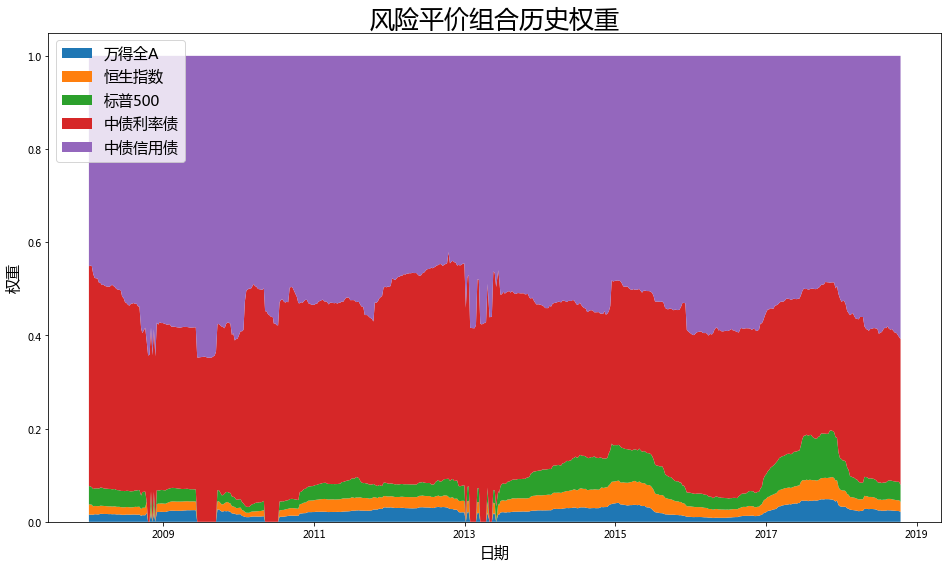

In [189]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['881001.WI'],
                 weight_plot['HSI.HI'],
                 weight_plot['SPX.GI'],
                 weight_plot['CBA00301.CS'],
                 weight_plot['CBA02701.CS'], 
                 labels=[u'万得全A', u'恒生指数', u'标普500', u'中债利率债', u'中债信用债'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)

In [190]:
metric(portfolio_ret)

Annual return: 5.15%
Sharpe ratio: 2.74
Annual volatility: 1.84%
Max drawdown: -3.20%


Text(0.5,0,u'\u65e5\u671f')

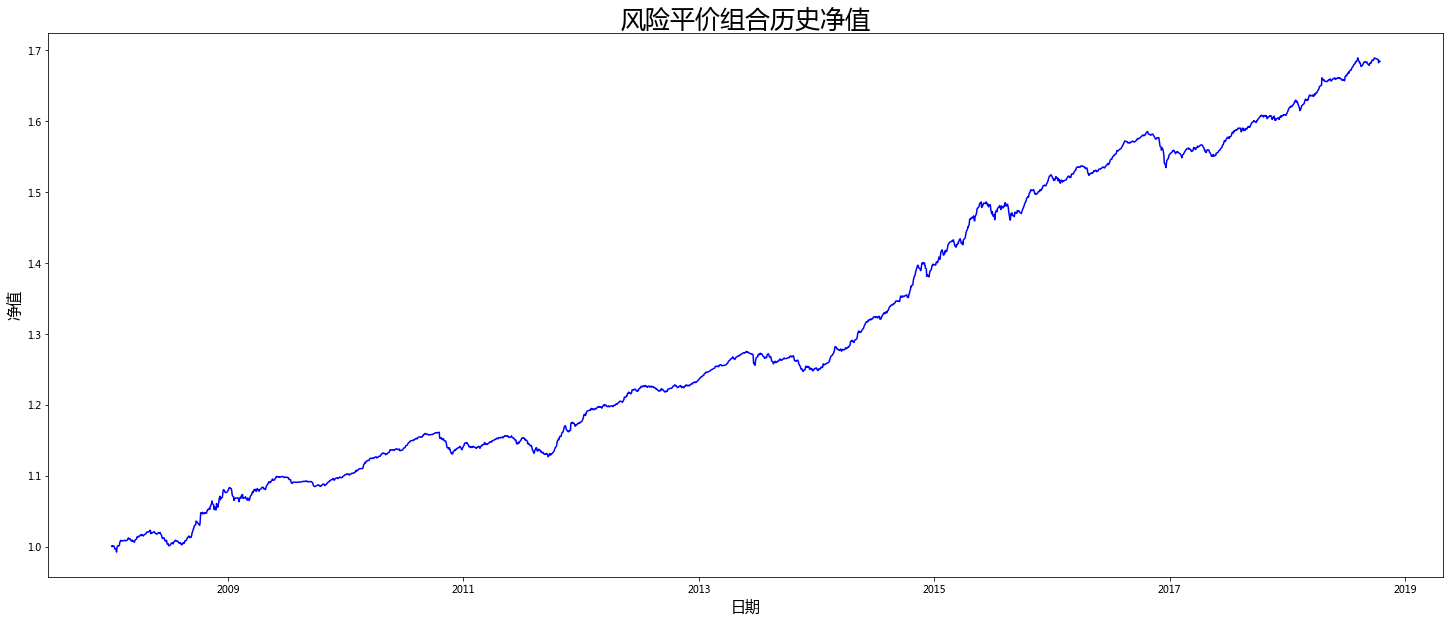

In [191]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue')
ax.set_title(u'风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)

## 择时后的风险平价

In [215]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4: # 周五调仓
        if date in st_li_df.index:
            st_li = st_li_df[st_li_df.index <= date]['z'][-5:].max()
        else:
            st_li = 0
        if date in bd_li_df.index:
            bd_li = bd_li_df[bd_li_df.index <= date]['z'][-5:].max()
        else:
            bd_li = 0
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            # calculate risk budget
            assets_risk_budget = get_assets_risk_budget(st_li=st_li, bd_li=bd_li)
            # calculate weight
            wb = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)
        if bd_li > 2:
            print date, bd_li, wb
        rc = _assets_risk_contribution_to_allocation_risk(np.matrix(wb), covariances.values)
        if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
            print(date)
            wb = temp.copy()

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


2013-04-26 00:00:00 2.308187618683588 [0.04470233 0.04985168 0.07106452 0.45571965 0.37866183]
2013-05-03 00:00:00 5.257507425635018 [0.05474722 0.06170303 0.08617229 0.47917193 0.31820553]
2013-05-10 00:00:00 2.159272856465956 [0.04410023 0.05108581 0.07036126 0.45622594 0.37822676]
2013-05-17 00:00:00 2.1910324271151387 [0.04126542 0.0495055  0.06616909 0.48282616 0.36023383]
2013-05-24 00:00:00 3.8178771936376146 [0.04794829 0.05611302 0.07769008 0.47634065 0.34190796]
2013-05-31 00:00:00 2.9877146194613924 [0.04370938 0.05198938 0.0709202  0.47161897 0.36176207]
2013-06-07 00:00:00 2.5067093568128436 [0.04299672 0.05188052 0.07257125 0.46194012 0.37061138]
2013-06-14 00:00:00 2.9005992745686973 [0.01143862 0.05866813 0.07410563 0.44638303 0.40940459]
2013-06-21 00:00:00 2.501202890892167 [0.02276638 0.08829947 0.1128403  0.33965415 0.4364397 ]
2013-06-28 00:00:00 3.118677952907864 [0.0189293  0.11119049 0.14589042 0.31476391 0.40922588]
2013-07-12 00:00:00 3.263116075296021 [0.0228

In [216]:
portfolio_ret1 = (weight * ret_df).sum(axis=1)
portfolio_ret1 = portfolio_ret1[portfolio_ret1 != 0]

In [217]:
metric(portfolio_ret1)

Annual return: 5.21%
Sharpe ratio: 2.56
Annual volatility: 1.99%
Max drawdown: -3.05%


Text(0.5,0,u'\u65e5\u671f')

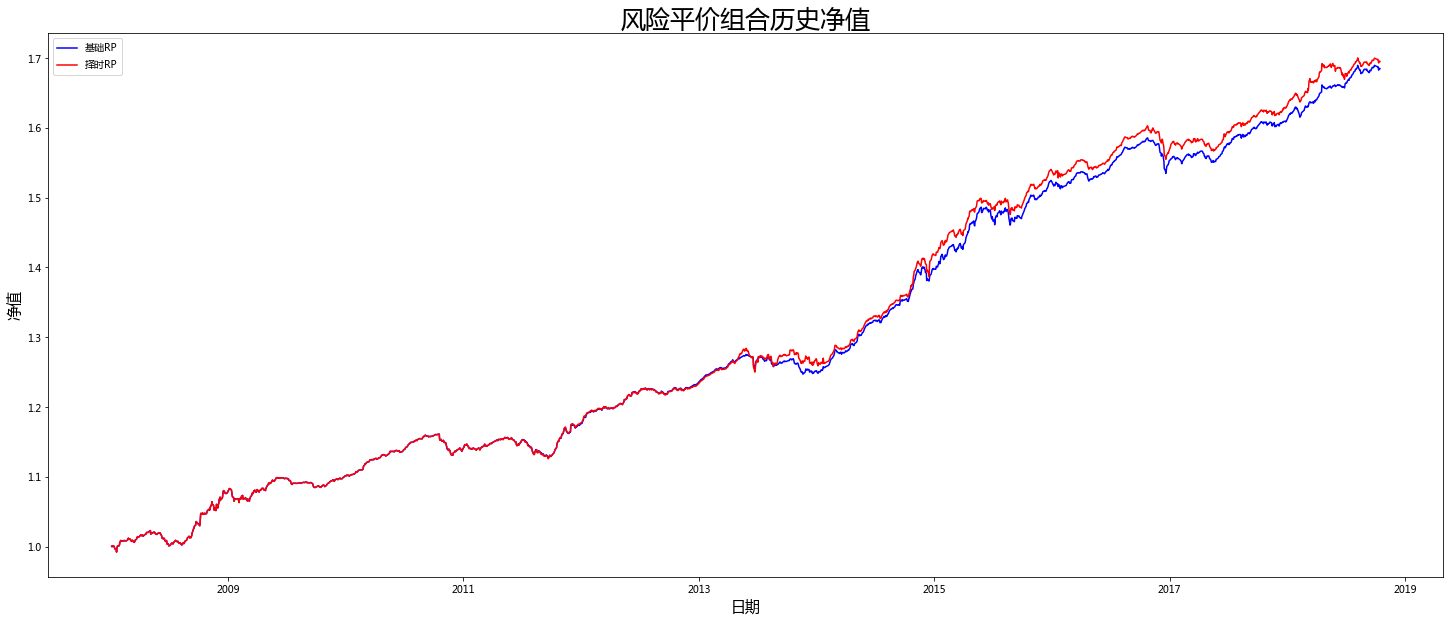

In [218]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue', label=u'基础RP')
ax.plot((1 + portfolio_ret1).cumprod(), color='red', label=u'择时RP')
ax.legend()
ax.set_title(u'风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)